<a href="https://colab.research.google.com/github/ikucherevsky/DeepLearning/blob/master/MNIST_adversarial_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
import random
%matplotlib inline

## Download data

In [ ]:
BATCH_SIZE=400
transform1 = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),transforms.ToTensor()])
train_dataset = datasets.MNIST('.', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('.', train=False, transform=transform1, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

4

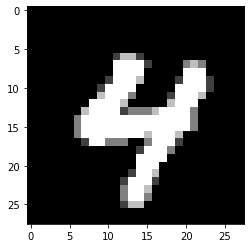

In [ ]:
idx = random.randint(0,60000)
plt.imshow(train_dataset[idx][0].numpy().reshape(28,28), cmap='gray')
train_dataset[idx][1]

## Formation and training LeNet 

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
               % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))


In [ ]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
class LeNet(nn.Module):
	def __init__(self):
		super(LeNet, self).__init__()
		self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
		self.conv2 = nn.Conv2d(6, 16, (5,5))
		self.fc1   = nn.Linear(16*5*5, 120)
		self.fc2   = nn.Linear(120, 84)
		self.fc3   = nn.Linear(84, 10)
	def forward(self, x):
		x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
		x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
		x = x.view(-1, self.num_flat_features(x))
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x
	def num_flat_features(self, x):
		size = x.size()[1:]
		num_features = 1
		for s in size:
			num_features *= s
		return num_features

In [ ]:
model = LeNet()
model.to(dev)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.RMSprop(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.8194, train acc 0.731, test acc 0.943, time 10.4 sec
epoch 2, loss 0.3256, train acc 0.898, test acc 0.960, time 10.4 sec
epoch 3, loss 0.2416, train acc 0.925, test acc 0.966, time 10.4 sec
epoch 4, loss 0.2010, train acc 0.938, test acc 0.976, time 10.3 sec
epoch 5, loss 0.1633, train acc 0.949, test acc 0.981, time 10.3 sec
epoch 6, loss 0.1460, train acc 0.954, test acc 0.979, time 10.3 sec
epoch 7, loss 0.1284, train acc 0.961, test acc 0.985, time 10.2 sec
epoch 8, loss 0.1176, train acc 0.963, test acc 0.987, time 10.4 sec
epoch 9, loss 0.1084, train acc 0.966, test acc 0.987, time 10.3 sec
epoch 10, loss 0.0962, train acc 0.970, test acc 0.988, time 10.3 sec


## Attack

In [ ]:
model = model.cpu()

In [ ]:
def attack(model = model, data = train_dataset, idx = 0, mode = 1, lr = lr):

  x = train_dataset[idx][0].clone()
  x.requires_grad_(True)
  with torch.no_grad():
    # значение выходов модели после прямого распространения
    logits = model(x.unsqueeze(0)).squeeze()
    # предсказание модели на неискаженном изображении
    IMX = torch.argmax(logits)
  #print("Init idx:",IMX.item())

  while True:
    logits = model(x.unsqueeze(0)).squeeze()
    
    imx = torch.argmax(logits)
    if imx!=IMX: 
        return x.detach().numpy(), imx.item()
    # клонирование выходов модели и установка целевого (неправильного) значения для правильного индекса
    y = logits.clone()
    y[imx] = -99
    loss = logits.max() - y.max() 
    loss.backward()
    
    # вычитаем из изображения lr * градиент, полученный при loss.backward()
    x.data.sub_(lr*x.grad.data)
    #print(loss.item(),logits.max().item(), y.max().item() )
    
    x.grad.data.zero_()
    if mode == 2:
      x.data.sub_(x.data.min())
    if mode == 3:
      x.data.sub_(x.data.min())
      x.data.mul_(1/x.data.max())

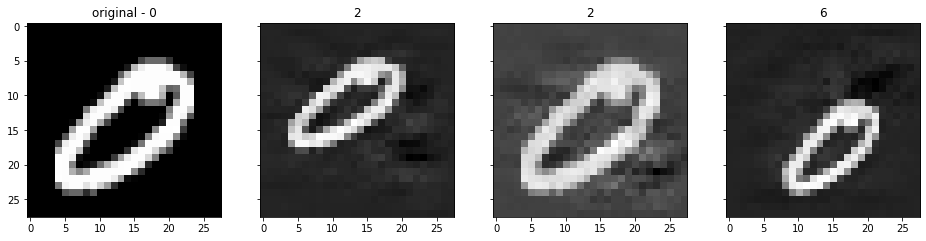

In [ ]:
# оригинальное значение и искаженные с предсказаниями для трех режимов
# режим 1 - вычитание из исходного изображения градиента * lr
# режим 2 - режим 1 и дополнительно вычитание минимального элемента из исходного изображения
# режим 3 - к режиму 2 добавляется деление на значение максимальной насыщенности изображения
idx = random.randint(0,60000)
image1,pred1 = attack(model = model, data = train_dataset, idx = idx, mode = 1, lr = lr)
image2,pred2 = attack(model = model, data = train_dataset, idx = idx, mode = 2, lr = lr)
image3,pred3 = attack(model = model, data = train_dataset, idx = idx, mode = 3, lr = lr)
fig, ax = plt.subplots(1,4, sharey=True, figsize=(16,4))
ax[0].set_title('original - ' + str(train_dataset[idx][1] ))
ax[0].imshow(train_dataset[idx][0].squeeze().numpy(), cmap='gray');
ax[1].set_title(str(pred1))
ax[1].imshow(image1.reshape(28,28), cmap='gray');
ax[2].set_title(str(pred2))
ax[2].imshow(image2.reshape(28,28), cmap='gray');
ax[3].set_title(str(pred3))
ax[3].imshow(image3.reshape(28,28), cmap='gray');